In [1]:
import cv2 as cv
import numpy as np
import scipy
import math
import os
import sys

import matplotlib
%matplotlib inline
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import face_alignment
import vrn_unguided


In [2]:
### initial 
enable_cuda = True
#
#FA = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, enable_cuda=False, flip_input=False)
FA = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
#
VRN = vrn_unguided.vrn_unguided
VRN.load_state_dict(torch.load('models/vrn_unguided.pth'))
if enable_cuda:
    VRN.cuda()

In [3]:
### get landmarks from test image
image_file = 'examples/star-0.jpg'
image = cv.imread(image_file)
try:
    image_height, image_width, image_depth = image.shape
except:
    print('cannot load image:', image_file)
#
preds = FA.get_landmarks(image)
print(len(preds))

1


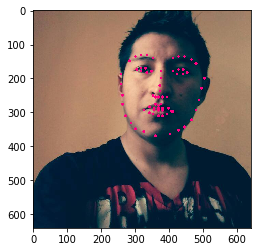

In [4]:
### landmarks  vis
canvas = image.copy()
minX=1000
maxX=0
minY=1000
maxY=0
for var in  preds[0]:
    if minX > var[0]:
        minX = var[0]
    if maxX < var[0]:
        maxX = var[0]
    if minY > var[1]:
        minY = var[1]
    if maxY < var[1]:
        maxY = var[1]
    
    cv.circle(canvas, (var[0], var[1]), 4, [128, 0, 255], thickness=-1)
#
plt.imshow(canvas[:,:,[2,1,0]])

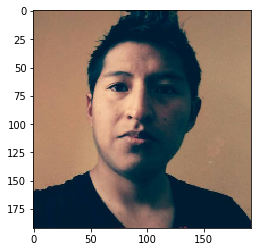

In [5]:
### crop face image
scale=90/math.sqrt((minX-maxX)*(minY-maxY))
width=maxX-minX
height=maxY-minY
cenX=width/2
cenY=height/2

x= int( (minX+cenX)*scale )
y= int( (minY+cenY)*scale )
#print x,y,scale

resized_image = cv.resize(image, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
rh,rw,rc =  resized_image.shape

#
crop_width = 192
crop_height = 192
left = 0
top = 0
right = 0
bottom = 0
cx = x
cy = y
if x < crop_width/2:
    left = crop_width/2 - x
    cx = x + left
if y < crop_height/2:
    top = crop_height/2 - y
    cy = y + top
if rw - x < crop_width/2:
    right =  crop_width/2 + x - rw;
if rh - y < crop_height/2:
    bottom = crop_height/2 + y - rh
#
crop_image = cv.copyMakeBorder(resized_image,int(top), bottom, left, right,cv.BORDER_REFLECT)
crop_image = crop_image[int(cy-crop_height/2):int(cy+crop_height/2), int(cx-crop_width/2):int(cx+crop_width/2), :]
plt.imshow(crop_image[:,:,[2,1,0]])

In [6]:
### vrn output
inp = torch.from_numpy(crop_image.transpose((2, 0, 1))).float().unsqueeze_(0)
if enable_cuda:
    inp = inp.cuda()
out = VRN(Variable(inp, volatile=True))[-1].data.cpu()
print(out.shape)

/home/ewilderd/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


torch.Size([1, 200, 192, 192])


/home/ewilderd/anaconda3/envs/conda_env/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/ewilderd/anaconda3/envs/conda_env/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [7]:
### save to obj file
import mcubes
from sklearn.neighbors import NearestNeighbors

im =  crop_image[:,:,[2,1,0]] #RGB
vol = out.numpy()
vol = vol.reshape((200,192,192))*255.0
vol = vol.astype(float)

vertices, triangles = mcubes.marching_cubes(vol, 10)

vertices = vertices[:,(2,1,0)]
vertices[:,2] *= 0.5 # scale the Z component correctly

r = im[:,:,0].flatten()
g = im[:,:,1].flatten()
b = im[:,:,2].flatten()

vcx,vcy = np.meshgrid(np.arange(0,192),np.arange(0,192))
vcx = vcx.flatten()
vcy = vcy.flatten()
vc = np.vstack((vcx, vcy, r, g, b)).transpose()
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(vc[:,:2])
n = neigh.kneighbors(vertices[:,(0,1)], return_distance=False)
colour = vc[n,2:].reshape((vertices.shape[0],3)).astype(float) / 255

vc = np.hstack((vertices, colour))

obj_file = 'output.obj'
with open(obj_file, 'w') as f:
    for v in range(0,vc.shape[0]):
        f.write('v %0.2f %0.2f %0.2f %0.2f %0.2f %0.2f\n' % (vc[v,0],vc[v,1],vc[v,2],vc[v,3],vc[v,4],vc[v,5]))

    for t in range(0,triangles.shape[0]):
        f.write('f {} {} {}\n'.format(*triangles[t,:]+1))

print('Calculated the isosurface, save at obj file:',obj_file)

Calculated the isosurface, save at obj file: output.obj


30


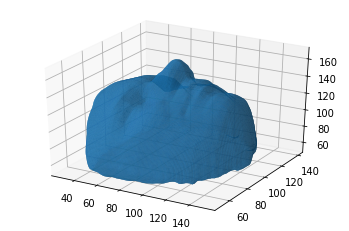

In [23]:
### plot 3d mesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

verts, faces = mcubes.marching_cubes(vol, 10)


#ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],cmap='Spectral', lw=1)
ax.plot_trisurf(verts[:, 1], verts[:, 2], faces, verts[:, 0])
# Get current rotation angle
print(ax.elev)
 
# Set rotation angle to 30 degrees
ax.view_init(elev=30)

In [20]:
print(ax.azim)

-60
